In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib
# matplotlib.use('pgf')

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
import numpy as np

%matplotlib inline


c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

markerlist = ['o', 4, 5, 6, 7, 'p', 'd', 'P']


text_width = 5.5  # in  --> Confirmed with template explanation
text_height = 9.0

fs_m1 = 7  # for figure ticks
fs = 9  # for regular figure text
fs_p1 = 10  # figure titles

axes_lw = 0.7

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('axes', linewidth=axes_lw)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1)  # fontsize of the figure title


matplotlib.rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})

matplotlib.rc('text', usetex=True)

plt.rcParams.update({'text.latex.preamble': r'\usepackage{amsfonts}'})


def errorfill(ax, x, y, yerr, color=None, alpha_fill=0.3, alpha_line=1, lw=1, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label=None):
    ax.fill_between(x, y - yerr, y + yerr, color=color, alpha=alpha_fill, linewidths=fill_linewidths)
    ax.plot(x, y, color=color, lw=lw, linestyle=linestyle, alpha=alpha_line, label=label, marker=marker, markersize=markersize)

def remove_xticks(ax):
    for tick in ax.xaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
    ax.xaxis.set_tick_params(which='minor', bottom=False, top=False)
    ax.xaxis.set_tick_params(which='major', bottom=False, top=False)
    ax.set_xticklabels([])
        
def remove_yticks(ax):
    for tick in ax.yaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
    ax.yaxis.set_tick_params(which='minor', left=False)
    ax.set_yticklabels([])


In [2]:
from scalable_gps.wandb_utils import load_runs_from_sweep
import numpy as np
import os

sweep_id = '20cojq3b'

n_splits = 5
n_steps = 100

config_keys = ['dataset_config.split', 'train_config.grad_variant', 'train_config.learning_rate']
metric_keys = ['train/alpha_rkhs_diff', 'train/y_pred_diff', 'train/normalised_test_rmse']

results_path = "./grad_variants.npy"

if os.path.isfile(results_path):
    results = np.load(results_path, allow_pickle=True).item()
else:
    results = dict()
    for grad_variant in ['vanilla', 'batch_kvp', 'batch_err', 'batch_all']:
        results[grad_variant] = dict()
        for lr in [7.5, 10, 20]:
            results[grad_variant][lr] = dict()
            for key in metric_keys:
                results[grad_variant][lr][key] = np.zeros((n_splits, n_steps))
    print(f"Downloading results...")
    configs_and_metrics = load_runs_from_sweep(sweep_id, config_keys, metric_keys, entity='jandylin', project='faster-sgd-gp')

    for (configs, metrics) in configs_and_metrics:
        split = configs['dataset_config.split']
        grad_variant = configs['train_config.grad_variant']
        lr = configs['train_config.learning_rate']
        for key in metric_keys:
            results[grad_variant][lr][key][split] = metrics[key]
    np.save(results_path, results)

100%|██████████| 60/60 [01:12<00:00,  1.20s/it]


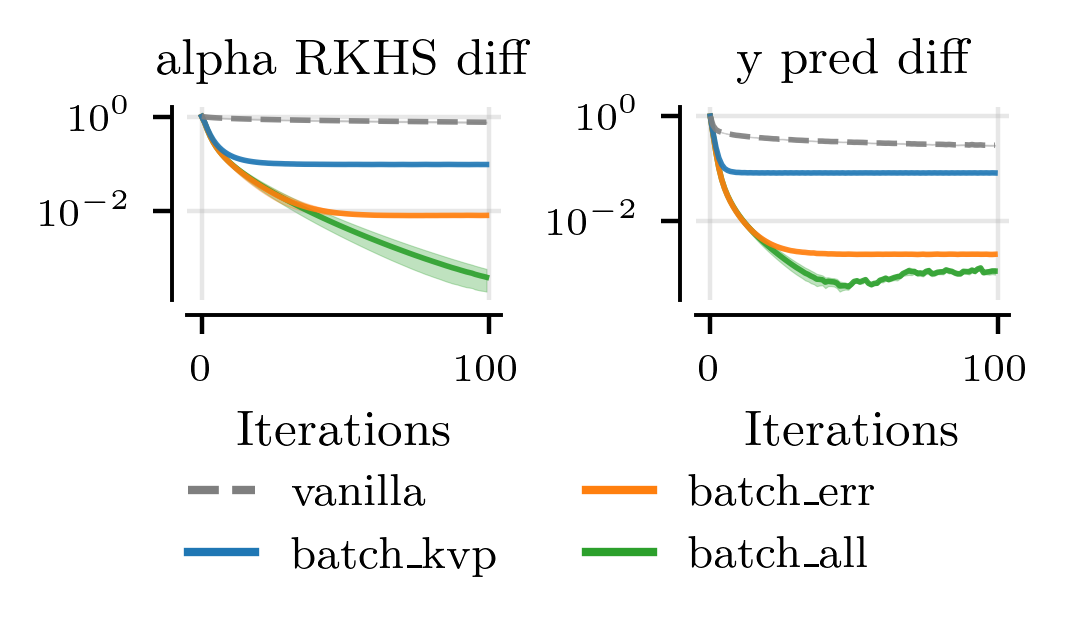

In [12]:
def get_mean_err(metric_key, grad_variant, lr):
    n_splits = results[grad_variant][lr][metric_key].shape[0]
    mean = np.mean(results[grad_variant][lr][metric_key], axis=0)
    err = np.std(results[grad_variant][lr][metric_key], axis=0) / np.sqrt(n_splits)
    return mean, err

def get_color(grad_variant):
    return {'vanilla': 'tab:gray',
            'batch_kvp': 'tab:blue',
            'batch_err': 'tab:orange',
            'batch_all': 'tab:green'}[grad_variant]

def get_ls(grad_variant):
    return '--' if grad_variant == 'vanilla' else '-'

alpha_line = 0.9
x_ticks = [0, 150, 300, 450]

# legend_handles = []
# for model in models:
#     for override_noise_idx in [0, 1]:
#         c = get_color(model, override_noise_idx)
#         legend_handles.append(Line2D([], [], color=c, label=get_label(model, override_noise_idx)))

fig = plt.figure(dpi=400, figsize=[.5 * text_width, 0.15 * text_height])

ax1 = fig.add_subplot(121)
ax1.set_title("alpha RKHS diff")
ax1.set_xlabel("Iterations")
ax1.grid(alpha=0.3)
ax1.spines[['top', 'right']].set_visible(False)
ax1.spines['bottom'].set_position(('axes', -0.075))
ax1.spines['left'].set_position(('axes', -0.05))
# ax1.semilogx()
ax1.semilogy()
# ax1.set_xlim(np.min(x_ticks), np.max(x_ticks))
# ax1.set_xticks(x_ticks)

ax2= fig.add_subplot(122)
ax2.set_title("y pred diff")
ax2.set_xlabel("Iterations")
ax2.grid(alpha=0.3)
ax2.spines[['top', 'right']].set_visible(False)
ax2.spines['bottom'].set_position(('axes', -0.075))
ax2.spines['left'].set_position(('axes', -0.05))
# ax2.semilogx()
ax2.semilogy()

# ax3 = fig.add_subplot(133)
# ax3.set_title("normalised test rmse")
# ax3.set_xlabel("Iterations")
# ax3.grid(alpha=0.3)
# ax3.spines[['top', 'right']].set_visible(False)
# ax3.spines['bottom'].set_position(('axes', -0.075))
# ax3.spines['left'].set_position(('axes', -0.05))
# # ax3.semilogx()
# ax3.semilogy()

# y_ticks, y_ticklabels = get_y_ticks(dataset)
# ax.set_ylim(np.min(y_ticks), np.max(y_ticks))
# ax.set_yticks(y_ticks)
# if y_ticklabels is not None:
#     ax.set_yticklabels(y_ticklabels)

for grad_variant in reversed(['vanilla', 'batch_kvp', 'batch_err', 'batch_all']):
    for lr in [20]:
        mean, err = get_mean_err('train/alpha_rkhs_diff', grad_variant, lr)
        errorfill(ax1, range(n_steps), mean, err, color=get_color(grad_variant), alpha_line=alpha_line, linestyle=get_ls(grad_variant))

        mean, err = get_mean_err('train/y_pred_diff', grad_variant, lr)
        errorfill(ax2, range(n_steps), mean, err, color=get_color(grad_variant), alpha_line=alpha_line, linestyle=get_ls(grad_variant))

        # mean, err = get_mean_err('train/normalised_test_rmse', grad_variant, lr)
        # errorfill(ax3, range(n_steps), mean, err, color=get_color(grad_variant), alpha_line=alpha_line, linestyle=get_ls(grad_variant))


legend_handles = [
    Line2D([], [], color=get_color('vanilla'), linestyle=get_ls('vanilla'), label='vanilla'),
    Line2D([], [], color=get_color('batch_kvp'), linestyle=get_ls('batch_kvp'), label='batch_kvp'),
    Line2D([], [], color=get_color('batch_err'), linestyle=get_ls('batch_err'), label='batch_err'),
    Line2D([], [], color=get_color('batch_all'), linestyle=get_ls('batch_all'), label='batch_all'),
]
fig.legend(handles=legend_handles, ncols=2, loc='center', bbox_to_anchor=(0.5, 0.0), fontsize=8, frameon=False, handlelength=1.5)

fig.tight_layout(w_pad=0.5, h_pad=0.2)
# fig.savefig(f"../../figures/grad_var_{dataset}.pdf", bbox_inches='tight', pad_inches=0.01)
# fig.savefig(f"../../figures/grad_var_{dataset}.png", bbox_inches='tight', pad_inches=0.01)
# plt.show()